# Baseline Setup for Semantic Segmentation (COVID-19 CT Images)

This notebook implements a baseline pipeline to segment COVID-19 lesions in CT images using semantic segmentation models in PyTorch. The lesions of interest are:

- Ground-glass opacities

- Consolidations

These features are known indicators of COVID-19 pneumonia and are usually labeled by radiologists. Automating this process can significantly reduce diagnosis time and aid in building AI-powered diagnostic tools.

## Challenge Objetive
Computed tomography (CT) is an essential tool for diagnosing and monitoring COVID-19, but manually segmenting lung abnormalities across hundreds of slices is time-consuming for radiologists. This challenge invites participants to develop automated methods to segment two key COVID-19-specific findings in CT scans: “ground-glass” opacities and “consolidations.” By accurately identifying these classes, the goal is to advance CT-specific software solutions that can accelerate and improve the evaluation of lung damage in COVID-19 patients.

### Install and import dependencies

In [ ]:
# Install segmentation_models_pytorch library for high-level segmentation models
!pip install segmentation_models_pytorch

In [ ]:
# Core libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

# Image processing
import cv2
from PIL import Image
import albumentations

# Progress bar
from tqdm.notebook import tqdm

# Segmentation models library
import segmentation_models_pytorch as smp

# Choose GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Explore input files

In [ ]:
# List all files in the input directory to confirm dataset availability
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-segmentation/masks_medseg.npy
/kaggle/input/covid-segmentation/images_medseg.npy
/kaggle/input/covid-segmentation/test_images_medseg.npy
/kaggle/input/covid-segmentation/masks_radiopedia.npy
/kaggle/input/covid-segmentation/images_radiopedia.npy


These .npy files store image arrays and corresponding segmentation masks for training and testing.

### Load the data

In [63]:
prefix = '/kaggle/input/covid-segmentation/'

images_radiopedia   = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia    = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg       = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg        = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)
test_images_medseg  = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

The .npy files contain 3D volumetric CT scans and segmentation masks, already preprocessed into numpy format. We load them into memory and convert to proper data types:

- float32 for continuous-valued image data

- int8 for class labels in masks (to save memory)

### Visualization utility
This function can show grayscale CT images, display true masks (one-hot encoded) and overlay predicted vs actual masks using RGB channels (green = GT, red = prediction).

This helps visually understand where the model is making mistakes to confirm data integrity (images and masks align) and make comparisons model predictions vs ground truth during evaluation.

In [64]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    _, ax       = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode: 
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        else: 
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

### Mask conversion

Now, we converts the segmentation output into a colored RGB image for easier interpretation.

This function uses np.argmax() to get class index per pixel. And maps each class index to an RGB value from a given palette.

In [65]:
def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

### Image preprocessing/normalization

Then, we clipping, to ensure the lung tissue on Hounsfield scale; robust scaling to eliminate data outliers; and z-score standarization inorder data could converge in a quicker way while loading it to model. We do this to ensures consistent input distribution across scans.

In [66]:
def preprocess_images(images_arr, mean_std=None):
    # Clipping
    images_arr[images_arr > 500]    = 500
    images_arr[images_arr < -1500]  = -1500
    # Robust scaling
    min_perc, max_perc  = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid    = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    # Standarization
    mean, std           = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr          = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

Steps:

1. Clipping: Caps intensity values to within [-1500, 500] Hounsfield Units.

2. Robust scaling: Determines 5th and 95th percentiles and restricts standardization to this central range.

3. Z-score normalization: Normalizes the entire array using the computed mean and standard deviation.

After this steps we obtain a normalized image array and a tuple with (mean, std) values for reuse.

#### Histogram plotting

Finally, we plot the pixel intensity distributions of one or two sets of images to validate the effect of preprocessing by comparing raw vs standardized image histograms.

In [67]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show()

## Model Training & Evaluation Pipeline

### Evaluation metrics

To assess the performance of our model during training and validation, we define two key metrics: pixel accuracy and mean Intersection over Union (mIoU).

The next function computes the ratio of correctly predicted pixels over the total number of pixels.

First, we apply softmax to convert the model’s output logits into probabilities. We use argmax to obtain the class with the highest predicted probability at each pixel. Then, we compare it element-wise with the ground truth mask.

The accuracy is computed as the number of correct predictions divided by the total number of pixels.

In [68]:

def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


This metric gives us a general idea of how well the model is predicting labels across all pixels. However, it may be biased if the background class dominates the image.

Then, we calculate the mean Intersection over Union (mIoU) across all pixel classes.

First, we convert the predicted logits into class labels. For each class, we compute the intersection (true positives) and union (true positives + false positives + false negatives).

If a class is not present in the ground truth, we skip it to avoid distorting the average. The final result is the mean of the per-class IoUs, excluding NaN values.

In [69]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

### Learning rate tracking

We track the learning rate across epochs to understand how the learning scheduler affects convergence.

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

### Training and validation loop

This is the main training function where we:

- Train the model on the training set.

- Evaluate it on the validation set at each epoch.

- Monitor loss, mIoU, and accuracy.

- Save the model checkpoints when validation loss improves.

In the initialization we load setup timers, histories, and early stopping variables. For each epoch:

- **Training phase**: Here we forward pass through the model. Calculate loss and metrics (mIoU, accuracy). Then we backpropagate the loss, update weights and adjust learning rate using a scheduler.

- **Validation phase**: First we evaluate the model using the same metrics but in eval() mode. If the validation loss improves, we save the model. But, if validation loss does not improve for 7 consecutive epochs, the training stops early.

At the end of each epoch, we print a detailed report of loss and metric values. The function returns a dictionary called history that stores all metrics across epochs for visualization.

In [ ]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    """
    Entrena y valida un modelo de segmentación semántica durante un número de épocas.

    Args:
        epochs (int): Number of training epochs.
        model (torch.nn.Module): Pytorch model to train.
        train_loader (torch.utils.data.DataLoader): Training data Dataloaders.
        val_loader (torch.utils.data.DataLoader): Validation data Dataloaders.
        criterion (torch.nn.modules.loss): Model's loss function.
        optimizer (torch.optim.Optimizer): Pytorch optimizer (ej. Adam, SGD).
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        patch (bool, optional): Flags to use on images (default = False).

    Returns:
        dict: Dictionary with validation and training history, with next clues:
            - 'train_loss' (list[float]): Average training loss per epoch.
            - 'val_loss' (list[float]): Average validation loss per epoch.
            - 'train_miou' (list[float]): mIoU at training.
            - 'val_miou' (list[float]): mIoU at validation.
            - 'train_acc' (list[float]): Average precission at training.
            - 'val_acc' (list[float]): Avergae precission at validation.
            - 'lrs' (list[float]): Learning rate history pero epoch.
    """
    train_losses,val_iou,val_acc,lrs = [],[],[],[]
    test_losses,train_iou,train_acc  = [],[],[]
    min_loss    = np.inf
    decrease    = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since        = time.time()
        running_loss = 0
        iou_score    = 0
        accuracy     = 0
        #training loop
        model.train()
        for _, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            image = image_tiles.to(device)
            mask  = mask_tiles.to(device)
            #forward
            output = model(image)
            
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy  += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            

        else:
            model.eval()
            test_loss     = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for _, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    image = image_tiles.to(device); mask =mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet_efficientnet_b2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

It is implemented a form of early stopping that halts training if no improvement is seen in validation loss after 7 epochs. Additionally, the model is saved every 5th time the loss improves.

Finally, to better analyze model performance, we use three helper functions for plotting the training curves. 

In [ ]:
# Displays the evolution of training and validation loss per epoch.
def plot_loss(history):
    """
    Grafica la pérdida por época para entrenamiento y validación.

    Args:
        history (dict): Diccionario con el historial de entrenamiento y validación,
            debe contener las claves:
                - 'train_loss' (list[float]): Pérdida en entrenamiento por época.
                - 'val_loss' (list[float]): Pérdida en validación por época.

    Returns:
        None
    """
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

# Plots the mean IoU scores for both training and validation sets across epochs.
def plot_score(history):
    """
    Grafica el puntaje medio de IoU por época para entrenamiento y validación.

    Args:
        history (dict): Diccionario con el historial de métricas,
            debe contener las claves:
                - 'train_miou' (list[float]): Mean IoU en entrenamiento.
                - 'val_miou' (list[float]): Mean IoU en validación.

    Returns:
        None
    """
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

# Visualizes pixel-wise accuracy trends across training and validation phases.
def plot_acc(history):
    """
    Grafica la precisión por época para entrenamiento y validación.

    Args:
        history (dict): Diccionario con el historial de métricas,
            debe contener las claves:
                - 'train_acc' (list[float]): Precisión en entrenamiento.
                - 'val_acc' (list[float]): Precisión en validación.

    Returns:
        None
    """
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

## Prediction

These functions help us perform inference and calculate evaluation scores outside the training loop, such as on a single image or on the test set.

This first function moves both the image and the mask to the computation device. It then evaluates the model on a single image and calculates the mean Intersection over Union (mIoU) between the predicted mask and the true mask.

The function returns three outputs:

- masked: the class predictions represented as integers.

- score: the computed mIoU value.

- output: the full softmax prediction tensor.

In [72]:
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    model.eval()
    model.to(device)
    image = image.to(device)
    mask  = mask.to(device)

    with torch.no_grad():
        output = model(image)
        score  = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, output.permute(0, 2, 3,1)

This second function normalizes the test image using the same mean and standard deviation as in training. It then runs inference on the model in eval() mode. Finally, it applies the softmax function and reshapes the output so that it can be used for visualization.

In [73]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    t     = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.eval()
    
    model.to(device)
    image = image.to(device)
    
    with torch.no_grad():
        output = model(torch.unsqueeze(image,1))
        output = nn.Softmax(dim=1)(output)
    return output.permute(0, 2, 3,1)

This third function allows us to evaluate the model on a single image and return two outputs: the predicted class map and the pixel-wise accuracy of the prediction. Unlike predict_image_mask_miou, which returns mIoU, this version focuses exclusively on pixel accuracy.

Key steps:

- The model is set to evaluation mode and moved to the computation device.

- The input image and mask are also transferred to the same device.

- Softmax and argmax are applied to obtain the final class prediction for each pixel.

- The pixel_accuracy() function is called to compute the accuracy.

This function is particularly useful for quick evaluation and debugging on individual samples from the validation or test set.

In [74]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        output = model(image)
        acc    = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
        
    return masked, acc

### Converting RGB mask to One-Hot encoding

We convert an RGB segmentation mask of shape (H, W, C) into a one-hot encoded tensor of shape (H, W, K), where K is the number of classes.

For each color (class) defined in the palette, every pixel in the input mask is compared against that color using np.equal. If the RGB triplet matches, the corresponding pixel is assigned a True value for that class. Once all classes have been checked, the results are stacked together into a one-hot encoded 3D tensor.

In [75]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        equality  = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

Then, we run the model over the entire test dataset and calculates the mIoU score for each sample.

The process works by iterating through the test set. For every image–mask pair, it calls predict_image_mask_miou() to run inference, generate the predicted mask, and compute the mIoU score. All scores are then collected into a list and returned.

By doing so, this function provides detailed evaluation metrics across the test set and enables both per-sample and aggregate performance analysis.

In [76]:
def miou_score(model, test_set):
    score_iou = []
    for _, data in enumerate(tqdm(test_set)):
        img, mask = data
        _, score,_ = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

### Custom dataset class

We define a custom Dataset class that encapsulates our in-memory image and mask arrays, applies optional augmentations, and manages tensor conversion and normalization. This design is fully compatible with PyTorch’s DataLoader and ensures a seamless integration into the training pipeline.

The constructor (__init__) stores the input images and masks, together with optional augmentations defined through an Albumentations transform pipeline. It also accepts normalization parameters such as mean and standard deviation, which are applied consistently across all samples.

The data retrieval method (__getitem__) fetches the i-th image–mask pair. If augmentations are specified, they are applied at this point. The image is then converted into a PIL format and processed using torchvision transforms, while the mask is cast into a torch.LongTensor. This guarantees uniform preprocessing and formatting whether the dataset is used for training or validation.

The length method (__len__) simply returns the total number of samples within the dataset.

In addition, the class provides a patch tiling method (tiles(image, mask)) that splits large images and their masks into smaller, fixed-size patches of 512×768. This feature is particularly valuable for training in memory-constrained environments and for enabling sliding window prediction during inference on large CT scans.

The method operates by applying unfold() to extract patches from both the image and the mask, followed by a reorganization of tensor dimensions to match the expected model input format. In doing so, it allows segmentation models with fixed input size limitations to still process entire CT volumes efficiently and effectively.

In [77]:
class Dataset:   
    def __init__(self, images, masks,augmentations=None):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)
            
            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']
        
        if self.augmentations is None:
            image = Image.fromarray(image)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()
    
        return image, mask
    
    def __len__(self):
        return len(self.images)
    
    def tiles(self, image, mask):
        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

## Full training pipeline and model execution

In this section, we finalize our data preparation pipeline, apply preprocessing and augmentations, and configure our full training and evaluation routine using a U-Net segmentation model based on the EfficientNet encoder.

### Dataset interpretation and label filtering
The Radiopedia dataset provides complete CT volumes where each pixel is labeled with one of four possible classes:

- Class 0 - Ground-glass opacities - our first target class.

- Class 1 - Consolidations - our second target class.

- Class 2 - Lungs other - potentially abnormal but not relevant for prediction.

- Class 3 - Background (non-lung) - should be ignored.

For our segmentation task, we aim to train our model to predict only classes 0 and 1. Classes 2 and 3 are retained in the masks but not explicitly evaluated during mIoU computation.

We first visualize and verify the CT volumes:

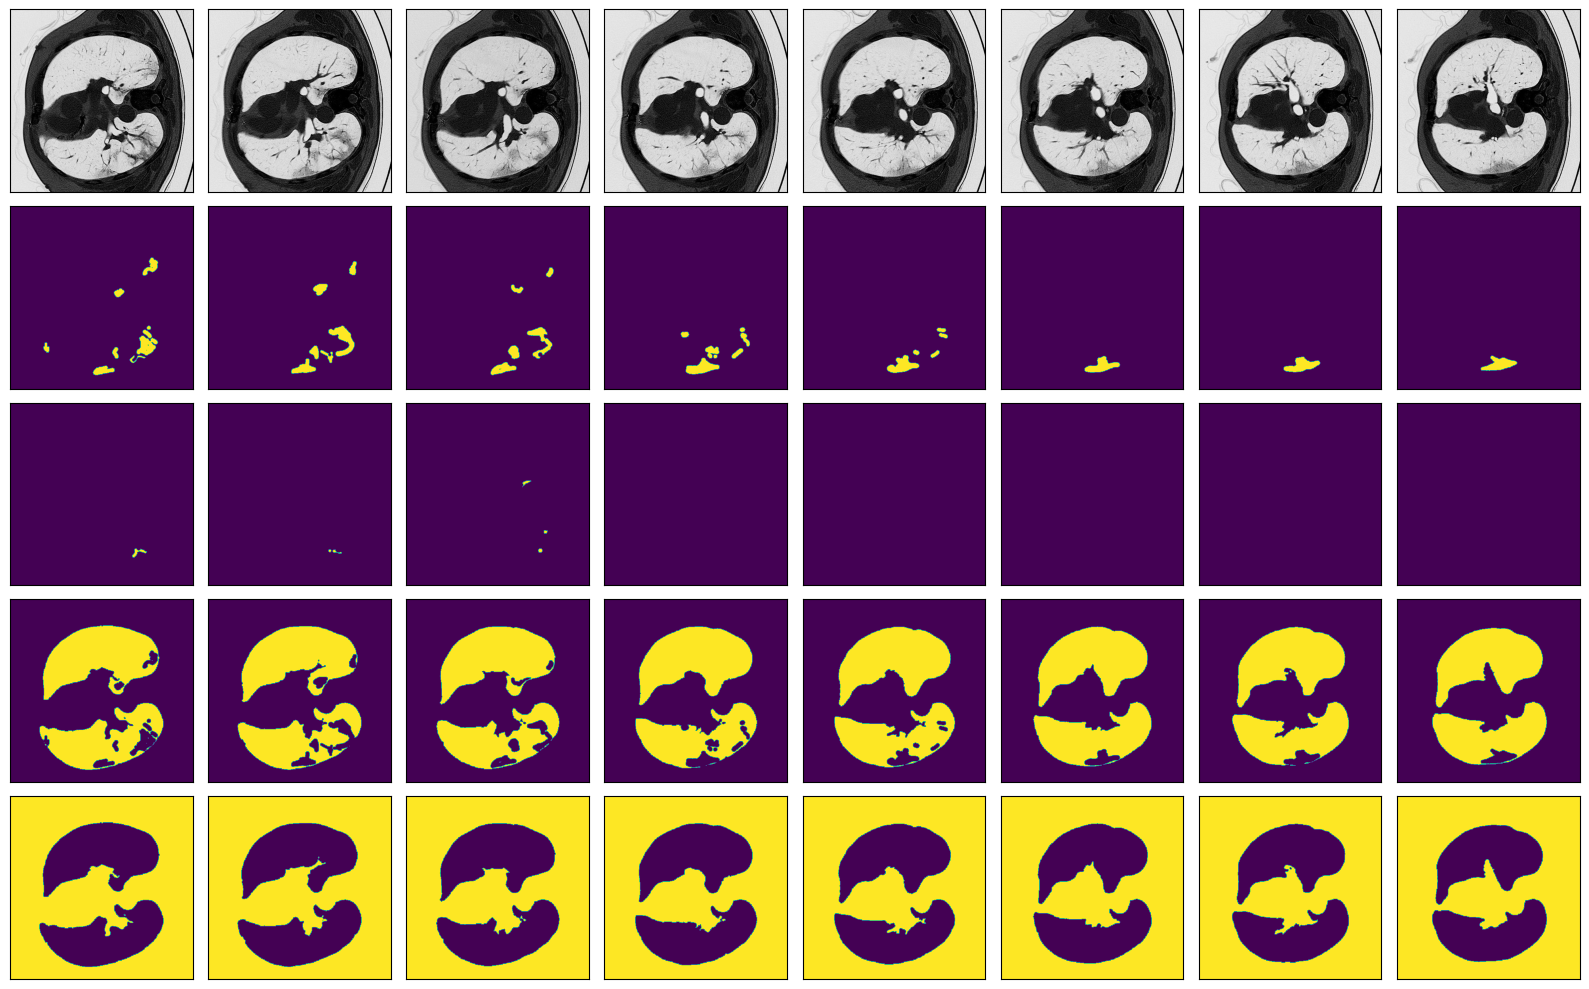

In [78]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

We then decode the one-hot encoded masks back to their class-index representation using the provided color palette:

Hot encoded mask size:  (829, 512, 512, 4)
Paletted mask size: (100, 512, 512)


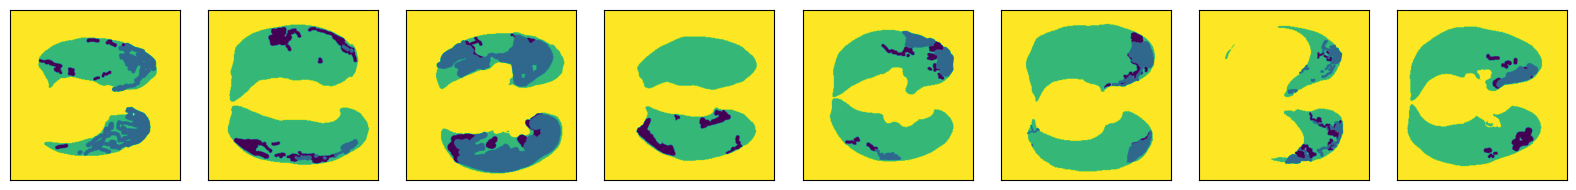

In [79]:
palette = [[0], [1], [2],[3]]
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)

masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

print('Hot encoded mask size: ',masks_radiopedia.shape)
print('Paletted mask size:',masks_medseg_recover.shape)

visualize(masks_medseg_recover[30:],hot_encode=False)

This transformation simplifies subsequent processing by representing the masks in 2D format (H, W) with integer values for each class.

## Image preprocessing

We apply the same preprocessing pipeline to all datasets: Radiopedia, MedSeg, and test sets. This includes:

- Clipping intensities to [-1500, 500]

- Robust scaling using the 5th and 95th percentiles

- Z-score standardization

To ensure consistency, we calculate mean and std from the Radiopedia dataset and reuse it for all other image sources.

In [80]:
images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.64862060546875, std 458.5678405761719
mean -451.64862060546875, std 458.5678405761719
mean -451.64862060546875, std 458.5678405761719


We then visualize histograms to confirm consistent scaling across datasets:

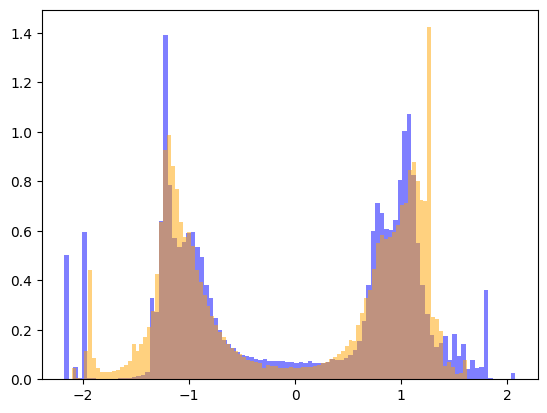

In [81]:
plot_hists(test_images_medseg, images_radiopedia)

## Data splitting and consolidation

We split the MedSeg dataset into training (76%) and validation (24%), and append the full Radiopedia dataset to the training set.

After this step, we free up memory by deleting large intermediate variables.

In [82]:
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
masks_medseg_recover     = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))
val_images = images_medseg[val_indexes]
val_masks = masks_medseg_recover[val_indexes]

batch_size = len(val_masks)

del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

## Data generator and augmentations

To improve generalization and reduce overfitting, we apply online data augmentation using the Albumentations library:

Training augmentations:
- Random rotation up to 360° with replication padding

- Random crop to 256×256 resolution

- Horizontal flipping

Validation augmentations:

- Resize only to 256×256

In [83]:
SOURCE_SIZE = 512
TARGET_SIZE = 256

train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   (TARGET_SIZE, TARGET_SIZE), 
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),

])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

We then define the dataset objects and data loaders:

In [84]:
train_dataset    = Dataset(train_images, train_masks, train_augs)
val_dataset      = Dataset(val_images, val_masks, val_augs)       
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

We validate the dataloader and encoding by visualizing samples:

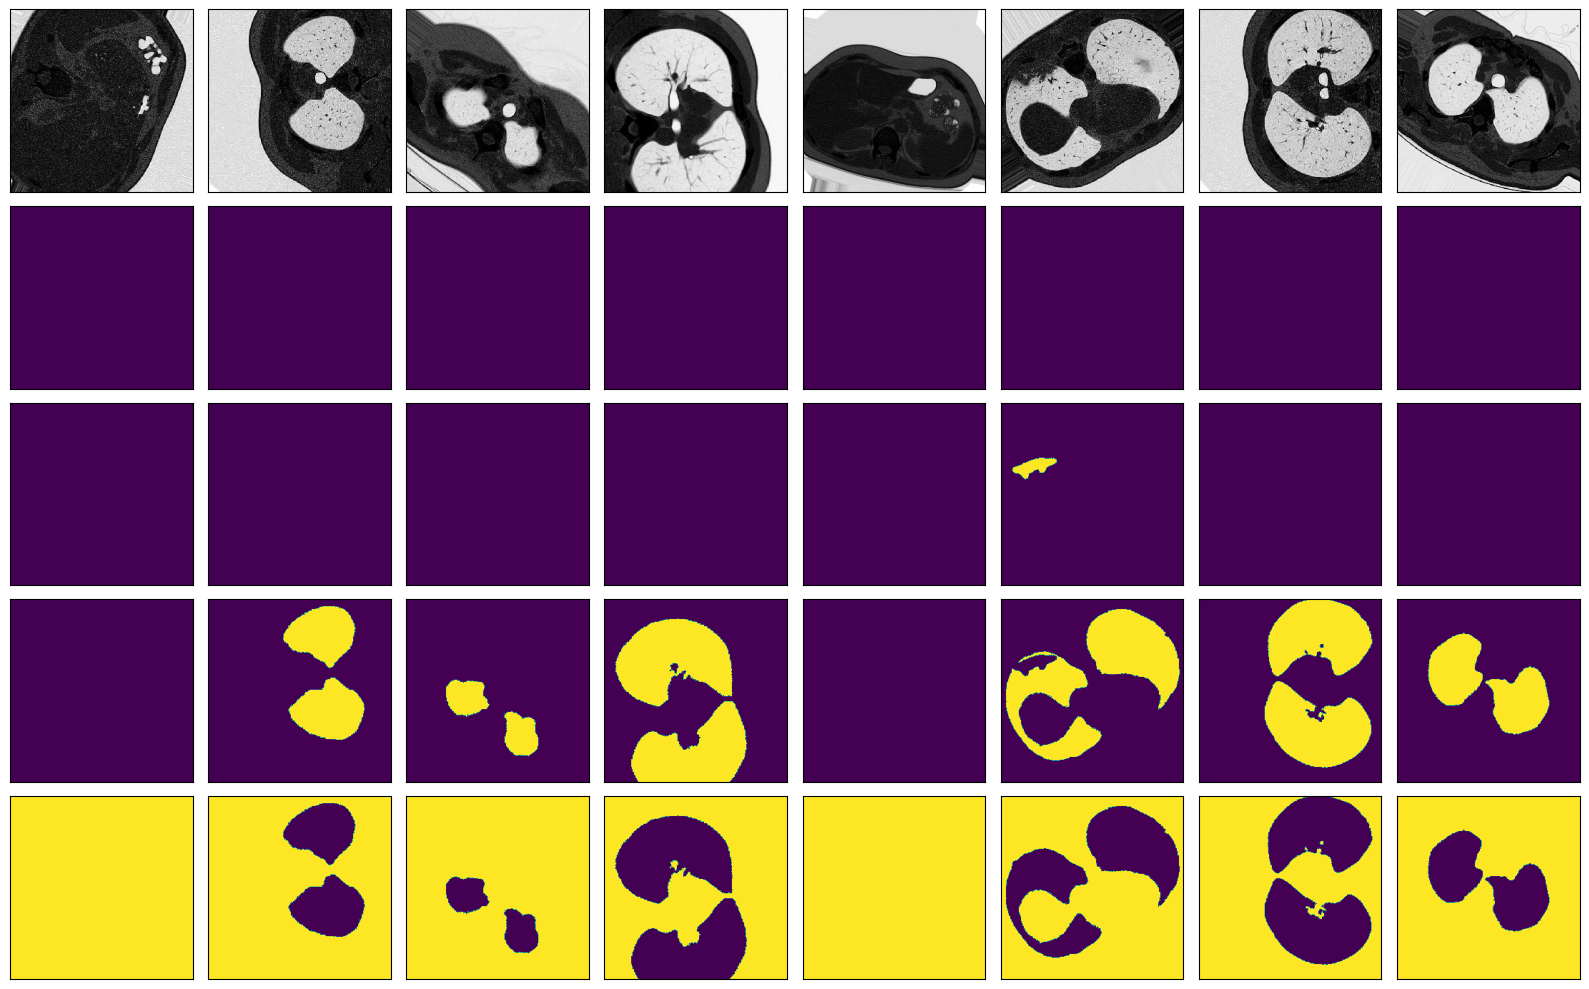

In [85]:
i,train_data     = next(enumerate(train_dataloader))
mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1],-1).numpy(),palette)
visualize(train_data[0].permute(0, 2, 3,1),mask_hot_encoded)

## Model definition: U-Net with EfficientNet-B2

We use the Segmentation Models PyTorch (SMP) library to instantiate a U-Net model with the EfficientNet-B2 encoder, pre-trained on ImageNet.

The model is configured to predict four classes and to accept grayscale input (1 channel).

In [86]:
model = smp.Unet('efficientnet-b2',in_channels=1, encoder_weights='imagenet',classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

### Training configuration

We configure the training pipeline using the hyperparameters.

- Loss function: Cross-entropy, suitable for multi-class pixel classification.

- Optimizer: AdamW with weight decay for regularization.

- Learning rate scheduler: OneCycleLR for dynamic learning rate adjustment.

Finally, we invoke the training loop using the fit() function we defined earlier.

In [87]:
max_lr       = 1e-3
epoch        = 10
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched     = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.467 
Epoch:1/10.. Train Loss: 1.578.. Val Loss: 1.467.. Train mIoU:0.139.. Val mIoU: 0.236.. Train Acc:0.306.. Val Acc:0.537.. Time: 0.31m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.467 >> 0.470 
Epoch:2/10.. Train Loss: 0.611.. Val Loss: 0.470.. Train mIoU:0.425.. Val mIoU: 0.416.. Train Acc:0.893.. Val Acc:0.905.. Time: 0.32m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.470 >> 0.287 
Epoch:3/10.. Train Loss: 0.177.. Val Loss: 0.287.. Train mIoU:0.557.. Val mIoU: 0.541.. Train Acc:0.974.. Val Acc:0.924.. Time: 0.31m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.287 >> 0.283 
saving model...
Epoch:4/10.. Train Loss: 0.098.. Val Loss: 0.283.. Train mIoU:0.598.. Val mIoU: 0.511.. Train Acc:0.979.. Val Acc:0.906.. Time: 0.31m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.283 >> 0.240 
Epoch:5/10.. Train Loss: 0.072.. Val Loss: 0.240.. Train mIoU:0.617.. Val mIoU: 0.535.. Train Acc:0.981.. Val Acc:0.919.. Time: 0.31m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.240 >> 0.199 
Epoch:6/10.. Train Loss: 0.064.. Val Loss: 0.199.. Train mIoU:0.620.. Val mIoU: 0.563.. Train Acc:0.982.. Val Acc:0.935.. Time: 0.31m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.199 >> 0.188 
Epoch:7/10.. Train Loss: 0.056.. Val Loss: 0.188.. Train mIoU:0.634.. Val mIoU: 0.570.. Train Acc:0.983.. Val Acc:0.937.. Time: 0.31m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.188 >> 0.183 
Epoch:8/10.. Train Loss: 0.052.. Val Loss: 0.183.. Train mIoU:0.644.. Val mIoU: 0.575.. Train Acc:0.984.. Val Acc:0.939.. Time: 0.31m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.183 >> 0.179 
saving model...
Epoch:9/10.. Train Loss: 0.051.. Val Loss: 0.179.. Train mIoU:0.641.. Val mIoU: 0.575.. Train Acc:0.984.. Val Acc:0.940.. Time: 0.31m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.179 >> 0.178 
Epoch:10/10.. Train Loss: 0.049.. Val Loss: 0.178.. Train mIoU:0.649.. Val mIoU: 0.577.. Train Acc:0.984.. Val Acc:0.940.. Time: 0.31m
Total time: 3.10 m


### Saving and visualizing results

After training, we save the model weights and generate training curves:

In [88]:
torch.save(model, 'Unet-efficientnet.pt')

These plots show how the model's loss, mIoU score, and pixel accuracy evolve across epochs for both training and validation sets.

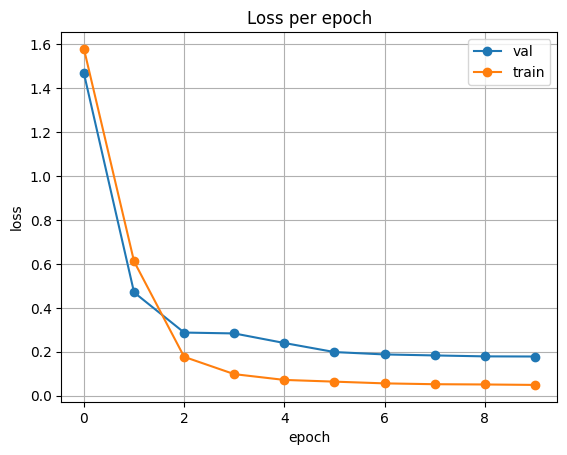

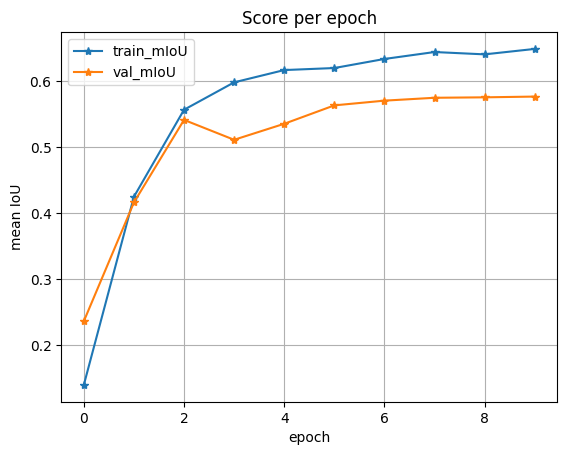

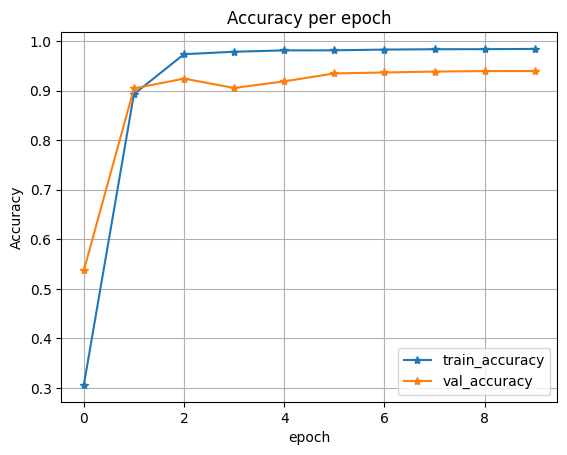

In [89]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## Evaluation

In this final section of our pipeline, we evaluate the trained model on the validation and test sets, visualize the results, and generate the final submission file in the required format.

### Visual inspection of validation predictions

To qualitatively evaluate how well our model is segmenting CT slices, we randomly extract a batch from the validation loader and visualize the predicted masks.

In [90]:
image, mask             = next(iter(val_dataloader))
pred_mask, score,output = predict_image_mask_miou(model, image, mask)
semantic_map            = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

We then convert the ground-truth mask into one-hot format and visualize both prediction and true label using our utility function.

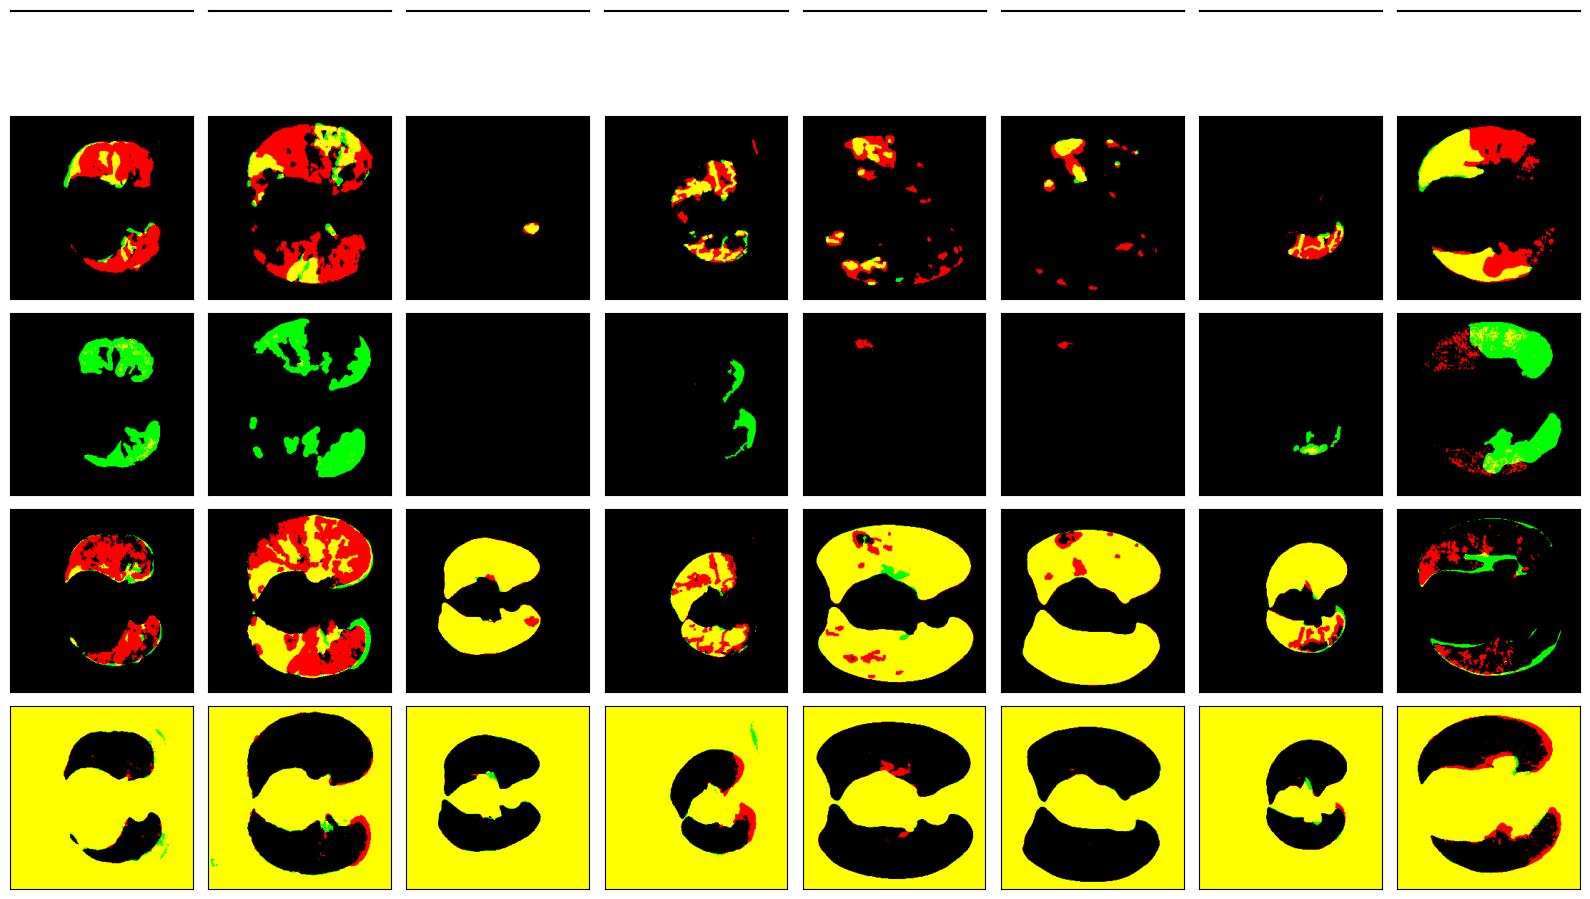

In [91]:
visualize(image.cpu(), semantic_map, pred_batch=output.cpu())

### Quantitative evaluation on validation set

To formally evaluate the model performance, we compute the mean Intersection over Union (mIoU) over the full validation dataset.

This gives us a list of mIoU scores for each image in the validation set, which can be used to calculate mean, standard deviation, or confidence intervals.

In [92]:
mob_miou = miou_score(model, val_dataloader)
mob_miou

  0%|          | 0/1 [00:00<?, ?it/s]

[0.5765710922013532]

We then free up memory by removing the training data arrays:

In [93]:
del train_images
del train_masks

### Test predictions

We now generate predictions on the unlabeled test set test_images_medseg, which contains 10 CT slices.

First. we apply the same resizing transformation used during validation to ensure input dimensions are compatible with the model. Then, we pass each image through the trained model and store the output predictions (softmax probabilities) in a batch. We then binarize the output by applying a threshold (> 0.5) to get the predicted class mask per pixel and visualize the final predicted masks.

torch.Size([10, 256, 256, 1])
(256, 256, 1)
(10, 256, 256, 4)


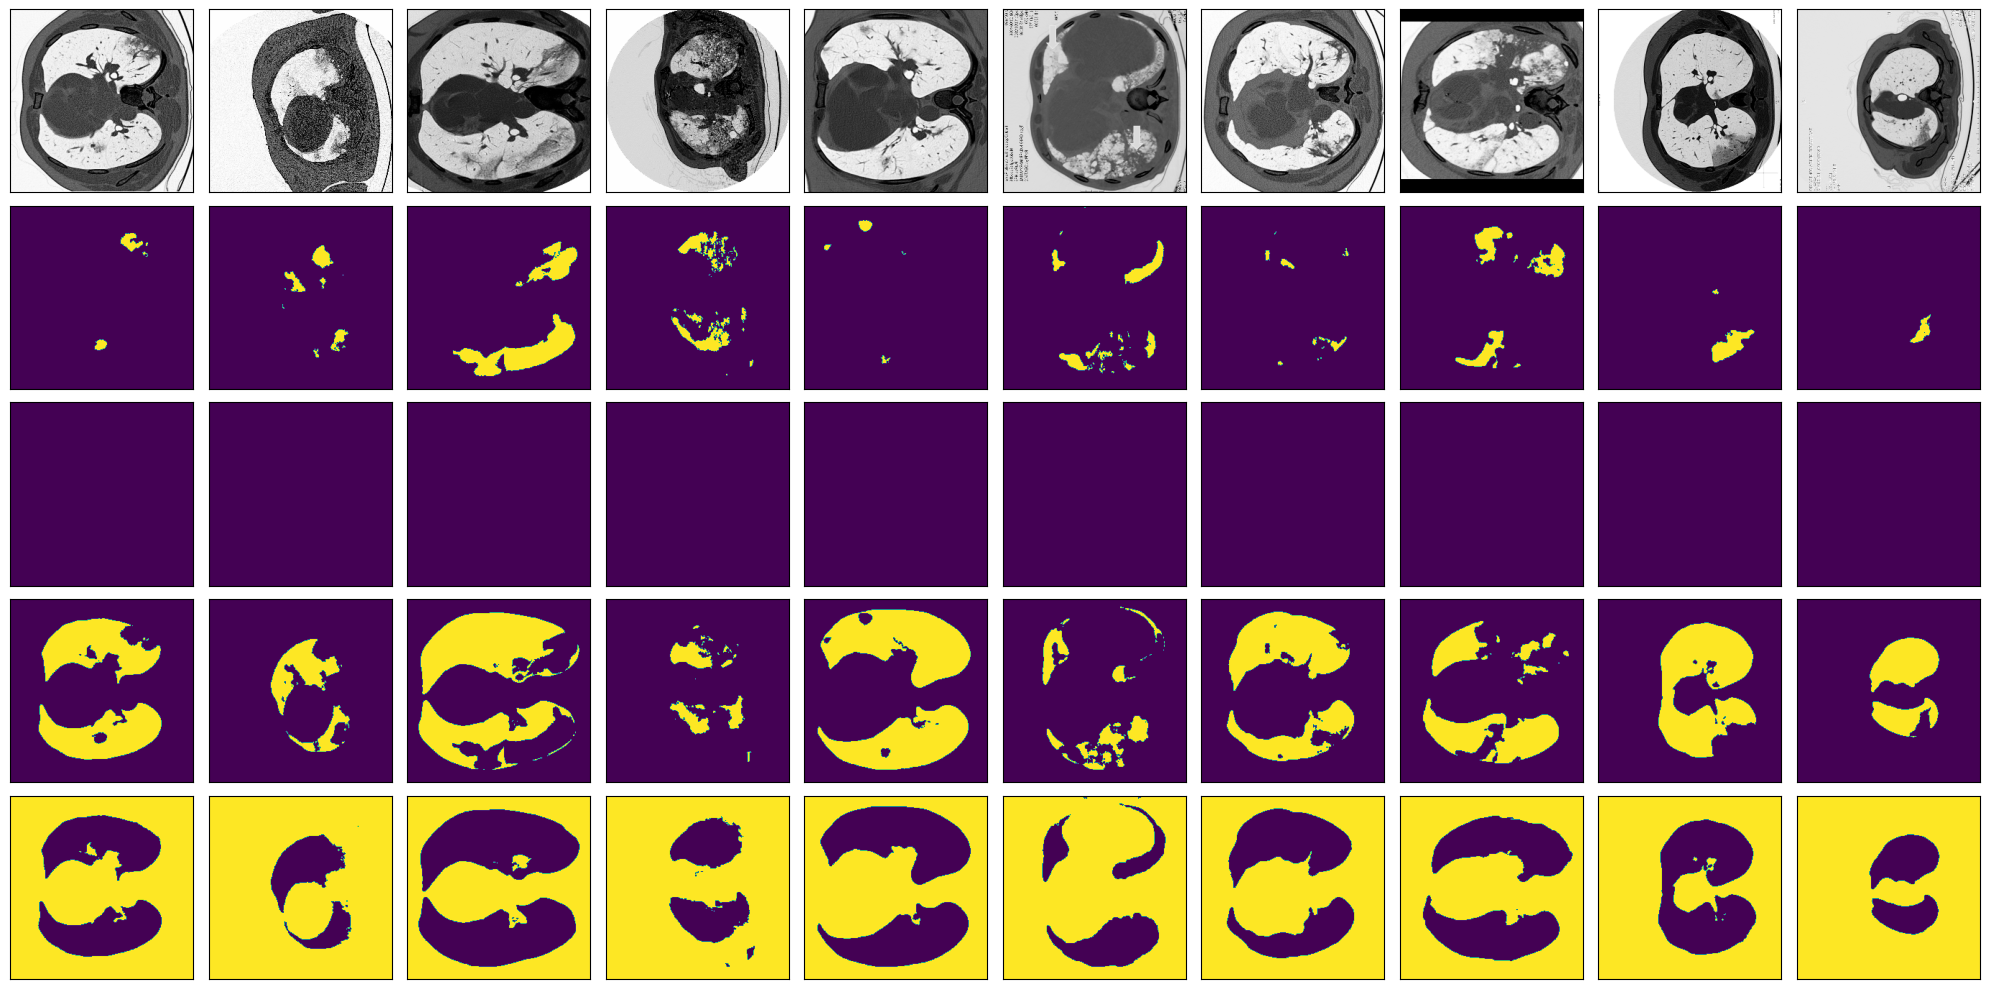

In [ ]:
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)
output = np.zeros((10,256,256,4))
for i in range(10):   
    output[i] = test_predict(model, image_batch[i]).cpu().numpy()
print(output.shape)
test_masks_prediction = output > 0.5
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

### Resize prediction to original size

Since the model was trained on 256×256 inputs, we now resize the predicted masks back to their original resolution (512×512) using nearest-neighbor interpolation (order=0).

This ensures alignment with the original CT image dimensions.

In [95]:
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

(10, 512, 512, 2)

### Final dataframe to challenge submission 

In [96]:
pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())), 
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1), 
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('sub.csv')

## References

- Cantoral Ph.D (2025). Youtube.com. https://www.youtube.com/watch?v=x_cY9l1cwj0

- Cantoral Ph.D (2025). Youtube.com. https://www.youtube.com/watch?v=dfMEK4bKjRE

- Igor.Slinko. COVID-19 CT Images Segmentation . https://kaggle.com/competitions/covid-segmentation, 2020. Kaggle.

- Maede Maftouni. (2021, May 8). PyTorch Baseline for Semantic Segmentation. Kaggle.com; Kaggle. https://www.kaggle.com/code/maedemaftouni/pytorch-baseline-for-semantic-segmentation
‌
- Tan, M., & Le, Q. V. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. ArXiv.org. https://arxiv.org/abs/1905.11946
‌
- Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. ArXiv.org. https://arxiv.org/abs/1505.04597